In [4]:
import sys
import os
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
print("Project root:", project_root)

if project_root not in sys.path:
    sys.path.append(project_root)

print("sys.path enthält project_root:", project_root in sys.path)

from model.simulation import load_scenario, simulate_load_profile

Project root: /Users/andregrau/Desktop/Thesis/Tool/Python_Tool/simLIS
sys.path enthält project_root: True


In [5]:
# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "office"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions = simulate_load_profile(scenario)

# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']}" " Tage")

Verwendetes Szenario: office
Erster Timestamp: 2025-04-17 00:00:00
Letzter Timestamp: 2026-04-16 23:00:00
Simulationshorizont: 365 Tage


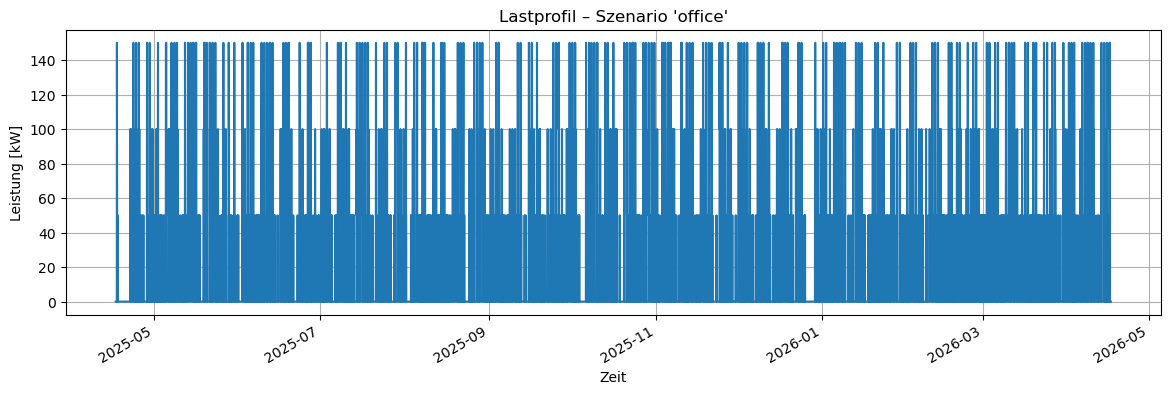

In [6]:
# ---------------------------------------------------------------------------
# Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()   # Datum auf der x-Achse lesbar machen
plt.show()